# Bayesian Inference

Depending on what you study in academia, it's common to only work with traditional frequentist statistics. That was certainly the case with me while studying health psychology. As I mentioned in a previous post, the key to understanding hypothesis testing in frequentist statistics is the idea that any test you do is evaluating the probability of the _data_ given the _hypothesis_ (the hypothesis being the null hypothesis--generally no difference in the population). This comes with all sorts of implications, mainly that you cannot evaluate the probability of any given hypothesis and you cannot incorporate any prior knowledge about a phenomenon into your hypothesis testing. The Bayesian approach turns all of this on its head. It combines your prior knowledge (or lack thereof) with observed data to give you the probability of the hypothesis given the data. I will not be offering a comprehensive discussion of the differences between frequentist and bayesian statistics here. There are plenty of great resources out there if you're curious, and I'll list a few of them below. Instead, I'll just work through a few examples of how to get posterior probability distributions given some prior knowledge and data. While calculating the posterior of single point estimates is simple, dealing with distributions is a little more complicated. For simple problems with conjugate priors, closed-form solutions may be possible; however, for many problems calculating the posterior is not analytically feasible. In these cases, we can instead _sample_ from the posterior distribution using Markov Chain Monte Carlo (MCMC) methods to obtain the desired estimates. Again, I will not be offering a comprehensive explanation of these methods or the math behind them. I will also list a few links for those resources as well.

__Helpful Links!__

_Bayesian Basics_

https://en.wikipedia.org/wiki/Bayesian_inference

https://brohrer.github.io/how_bayesian_inference_works.html

https://towardsdatascience.com/probability-concepts-explained-bayesian-inference-for-parameter-estimation-90e8930e5348

https://www.youtube.com/watch?v=Z55N8kBuMGs&list=PLFDbGp5YzjqXQ4oE4w9GVWdiokWB9gEpm&index=46

_Bayesian vs. Frequentist_

https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading20.pdf

https://www.youtube.com/watch?v=YsJ4W1k0hUg

https://xkcd.com/1132/

_MCMC_

https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50

https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a

https://www.youtube.com/watch?v=h1NOS_wxgGg

https://www.youtube.com/watch?v=OTO1DygELpY&t=177s

https://www.youtube.com/watch?v=-8VTcuCJF1s

_PYMC3_

https://docs.pymc.io/

https://www.youtube.com/watch?v=M-kBB2I4QlE&t=1328s

_A good textbook on probability_

https://www.amazon.com/Introduction-Probability-Models-Sheldon-Ross/dp/0123756863


Below: Two representations of Bayes' formula. The first is a general description. The second includes the tricky integral denominator which makes MCMC methods necessary for complex problems.

<img src="https://alexdatasci.com/wp-content/uploads/2019/09/bayes_eqs.png">

# Checking coin bias

I'll start with a simple problem. Let's say we find an ancient coin and want to determine the probability that it is "fair" (arbitrarily we'll define fair as probability of heads = .5 +/- .05). Let's also say that we know that someone else flipped a similar coin and recorded 19 heads out of 30 tosses. We decide to use that information as our prior and flip the coin 10 times to estimate its bias. There will necessarily be some uncertainty regarding the bias of the coin given our limited information, so what we really want is a probability density function that for all possible values of the bias (0-1). Luckily for us, the beta distribution provides us with exactly what we want and is also the conjugate prior of the binomial distribution. This means that in this case we can easily calculate the posterior analytically.

First, let's make some data and plot the data and prior distribution.

Flips:  [ True False False False False  True  True False False False] 
 N Heads=  3 
 N Tails=  7


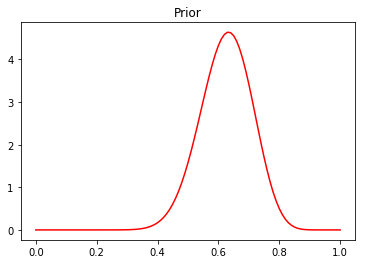

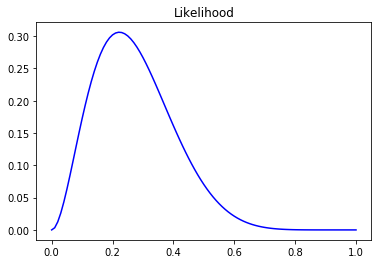

In [16]:
import numpy as np
from scipy.stats import beta, binom, norm
from matplotlib import pyplot as plt
np.random.seed(1234)

# Prior beta parameters
prior_a = 19
prior_b = 11

# Flip the coin!
n_flips = 10
coin_bias = .3
flips = np.random.uniform(size=n_flips)<coin_bias
heads = sum(flips)
tails = n_flips-sum(flips)
# Print flips, alpha and beta parameters
print('Flips: ', flips, '\n',
      'N Heads= ', heads, '\n',
      'N Tails= ', tails)

probs = np.arange(0,1.01,.01)

# Plot prior and data
plt.plot(probs, beta.pdf(probs, prior_a+1, prior_b+1), 
        color='Red')
plt.title('Prior')
plt.show()

plt.plot(probs, [binom.pmf(2,9,i) for i in probs],
        color='Blue')
plt.title('Likelihood')
plt.show()

With 3 heads and 7 tails, it sure seems like this coin might have a much lower heads bias. But with only 10 flips, how much should we let these results sway our expectation given our prior? With a beta distribution, updating the prior is very easy. We simply add the number of heads to alpha and number of tails to beta. The resulting distribution is displayed below along with the prior.

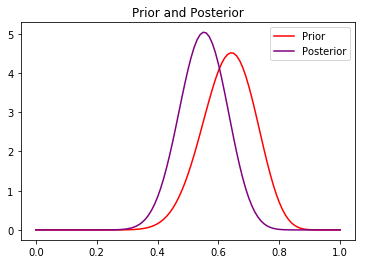

0.44999999999999996


In [2]:
plt.plot(probs, beta.pdf(probs, prior_a, prior_b), 
        color='Red')
plt.plot(probs, beta.pdf(probs, prior_a+heads, prior_b+tails),
        color='Purple')
plt.legend(('Prior', 'Posterior'))
plt.title('Prior and Posterior')
plt.show()
print(1/(1+(prior_a+heads)/(prior_b+tails)))

While the results of our little experiment do move the distribution, our relatively stronger prior constrains that movement. The expected value (1/1+a/b) is now about .45. Now to answer our original question. What is the probability that the coin's bias is "fair" (.45<p<.55)? A quick look at the beta distribution PDF can give us the answer:

In [3]:
p_fair = beta.cdf(.55, prior_a+heads, prior_b+tails) - \
beta.cdf(.45, prior_a+heads, prior_b+tails)

print('Probability that bias of coin is between .45 and .55 = ', 
      round(p_fair,2))

Probability that bias of coin is between .45 and .55 =  0.39


## A strange hypothetical

A while back I was asked a strange question during an interview. The interviewer asked me: "Given that you have one heads out of two flips, what is the most likely 'heads' bias of the coin, __and what is the 95% credible interval for that estimate?__" As someone whose vast majority of statistical training was in the frequentest tradition, this sort of question (calculating a confidence interval with N=2) was not something I had really considered. To be fair, this specific question has very little practical value, if any. After all, what is the point of assigning a confidence interval to a parameter with a sample size of 2?! Still, it's something that _can_ be computed, and had I brushed up on probability distributions and Bayesian inference adequately it would not have been a problem. Long story short, I had not and this question flustered me more than I'd like to admit. So now for some small small measure of vindication, here's a simple solution.

Since we're talking about Bayesian inference here, let's come up with quick prior. Specifically, that we know nothing about the coin except that it has a heads and a tails: a flat beta distribution with a=1 and b=1. Then all we have to do is update the prior with our new information (1 heads and 1 tails). This gives us the required posterior distribution, which we can then use to get the required interval very easily:

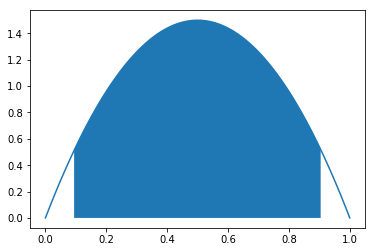

The 95% CI of the "heads" bais after getting 1 heads out of 2 flips =  
 (0.09429932405024612, 0.9057006759497539)


In [4]:
plt.plot(probs,
        beta.pdf(probs,2,2))
plt.fill_between(np.arange(beta.interval(.95,2,2)[0],
                   beta.interval(.95,2,2)[1],.01),
        beta.pdf(np.arange(beta.interval(.95,2,2)[0],
                           beta.interval(.95,2,2)[1],.01),
                 2,2))
plt.show()
print('The 95% CI of the "heads" bais after getting 1 heads out of 2 flips = ',
     '\n',beta.interval(.95,2,2))

__Always__ review probability distributions and some Bayesian basics before interviews is what I'm saying.

Note: I should briefly mention that credible intervals != confidence intervals. A very brief explanation is that a 95% confidence interval (frequentist approach) is designed to contain the "true" population mean 95% of the time. Since the Bayesian approach does not consider parameters to be fixed, instead we have credible intervals, in this case the range simply represents 95% of the distribution by area, centered around the mean.

# Normal prior, normal likelihood, known variance

The coin flips example is a good place to start when warming up to Bayesian inference, because it's easy to conceptualize and the prior is very easy to update. What about other types of distributions? Normal distributions pop up __all the time__, so it's a good idea to know how to work with them in a Bayesian context. For simple, trivial problems, normal distributions are _fairly_ easy to update. I say fairly easy because the simplified equations for updating the parameters of the prior exist. However, getting to those simple equations from the "raw" bayesian formula already <a href="http://www.ams.sunysb.edu/~zhu/ams570/Bayesian_Normal.pdf" target="_blank">takes quite a bit of math</a>. Once you encounter problems that entail more than a couple parameters of theta, the integration required in the denominator of the Bayes formula becomes intractable. More on that later. For now, here's a quick example of Bayesian inference with a normal prior and likelihood with a known variance.

First, I'll define some functions to get the likelihood and posterior distributions (see the link above for the equations used in the posterior function).

In [5]:
def likelihood(data, m, data_sd):
    return np.array([(1/np.sqrt(2*np.pi*data_sd**2))*\
                     np.exp(-((x1-m)**2) / (2*(data_sd**2))) for x1 in data]).prod()

def posterior(x, x_sd, prior_m, prior_sd):
    '''Returns posterior mean and sd'''
    var_den_1 = prior_sd**2
    var_den_2 = x_sd**2/len(x)
    var = (1/var_den_1 + 1/var_den_2)**-1
    
    m = var*(prior_m/prior_sd**2 + x.mean()/(x_sd**2/len(x)))
    
    return m, np.sqrt(var)

Now I'll say that I have an set of N observations, and a prior mean (of the parameter "mean") of 5 with a standard deviation (of the parameter "mean") of 1. I'll also "gather" some random data of a particular mean and sd. 

In [6]:
np.random.seed(1234)
N = 5
prior_m = 5
prior_sd = 1
data_m = 2
data_sd = 3
x = np.arange(-3,10.1,.1) # For plotting
data = np.random.normal(data_m,
                        data_sd,
                        N)

Finally, I'll calculate the posterior and plot everything. Keep in mind that likelihood distribution is NOT a proper pdf as it will not integrate to 1 (note the tiny scale). 

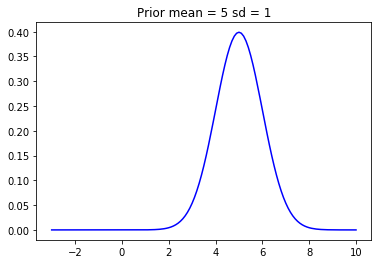

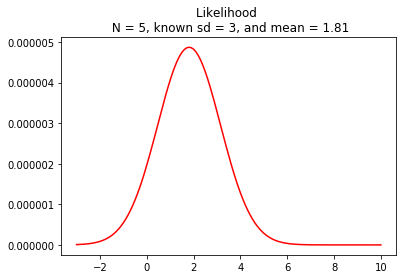

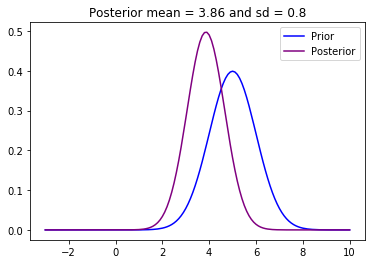

In [7]:
np.random.seed(1234)

pos_mean, pos_sd = posterior(data, data_sd, 5, 1)
plt.plot(x,
        norm.pdf(x, prior_m, prior_sd),
        color='Blue')
plt.title(f'Prior mean = {prior_m} sd = {prior_sd}')
plt.show()

plt.plot(x,
        [likelihood(data, i, data_sd) for i in x],
        color='Red')
plt.title(f'Likelihood \n N = {N}, known sd = {data_sd}, and mean = {round(data.mean(),2)}')
plt.show()

plt.plot(x,
        norm.pdf(x, prior_m, prior_sd),
        color='Blue')
plt.plot(x,
        norm.pdf(x, pos_mean, pos_sd),
        color='Purple')
plt.title(f'Posterior mean = {round(pos_mean, 2)} and sd = {round(pos_sd, 2)}')
plt.legend(('Prior', 'Posterior'))
plt.show()

This was a pretty easy example, but highlights how Bayesian inference works with normal distributions fairly intuitively. As with the coin flip problem, the posterior is a mix of the prior with the infromation gained from the data. In practice, it's rare that you'll always know the variance of a distribution. Next we'll go through an example where both the mean and sd of a distribution are updated using a different approach.

# MCMC

When problems move beyond the trivial, it becomes impossible calculate all the posterior parameters analytically (because integration over lots of parameters in the denominator of the Bayes equation is difficult). Instead, Markov Chain Monte Carlo methods are used to sample from the posterior distribution. I won't go through the math here (see above for some links that explain these methods far better than I can), but the general intuition is that random sampling of possible values of theta coupled with clever rules for accepting or rejecting those proposals will result in a distribution of accepted proposals that is asymptotically equivalent to the posterior distribution. Basically, with a sufficiently large sample these methods produce a distribution that matches the posterior _close enough_ to make reasonable estimations of the parameters of theta. 

First, I'll demonstrate how these methods can reproduce our previous analysis. Then I'll use them on the same problem but with unknown variance (this problem is still fairly simple, but I'll use MCMC anyway to highlight the API). I'll use the pymc3 library for these analyses.

## Previous Example

First I'll reproduce the example from above using the same data. Let's see how they compare!

/Users/alex/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/alex/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:06<00:00, 3167.18draws/s]


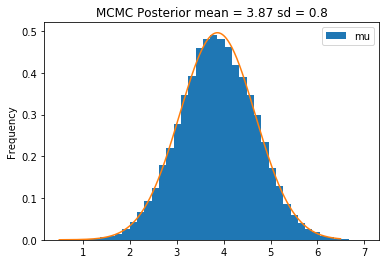

In [8]:
import pymc3 as pm

with pm.Model() as simple_model:
    
    # Prior
    mu = pm.Normal('mu', mu=prior_m, sigma=prior_sd)
    sigma = data_sd
    
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)
    
    trace = pm.sample(10000, target_accept=.9, random_seed=42)

trace_df = pm.trace_to_dataframe(trace)

trace_df.plot(kind='hist',bins=40,density=True)
plt.plot(np.arange(0.5,6.5,.01),
        norm.pdf(np.arange(0.5,6.5,.01),
                trace_df.mean(), trace_df.std()))
plt.title(f'MCMC Posterior mean = {float(trace_df.mean().round(2))}' + 
          f' sd = {float(trace_df.std().round(2))}')
plt.show()

That essentially the same result (rounded numbers may be slightly different). Because these distributions are generated using stochastic processes, the exact numbers will vary slightly from run to run unless you use a seed.

## Unknown Mean and Variance

Now let's look at a slightly more complex model. This time, we'll say that we do not know the standard deviation of the distribution and will need to estimate it. This leads us again to the question of what prior to choose. Although this is a hypothetical and we can chose anything we'd like, it's interesting to think about what type of distribution we should choose for the standard deviation. Since standard deviations are always positive, a normal distribution is probably not appropriate (it will _approach_ normal asymptotically due to the central limit theorem, but it's not appropriate here). In reality, it will follow a gamma distribution, but instead of specifying that I'll pretend we don't have a good idea of what shape it will follow and assign it a wide uniform distribution between 0 and 10.

In [9]:
with pm.Model() as model_mv:
    
    # Prior
    mu = pm.Normal('mu', mu=prior_m, sigma=prior_sd)
    sigma = pm.Uniform('sigma', 0, 10)
    
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)
    
    trace_mv = pm.sample(10000,random_seed=42, target_accept=.9)

trace_mv_df = pm.trace_to_dataframe(trace_mv)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:10<00:00, 1941.98draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8345720899690038, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


We get some warnings here that we need to pay attention to. I'm not an expert in the nuts and bolts of these algorithms, but if you read through some documentation on pymc3, "The number of effective samples is smaller than 25% for some parameters" indicates that there may be strong autocorrelation between samples. Without getting into too many details, the posterior distribution is estimated by using a Markov Chain, meaning that each random sample is dependent on the previous sample. This necessarily leads to autocorrelation. Over a sufficient number of samples, the posterior is still a very good aproximation, but it's necessary to deal with that autocorrelation one way or another. Setting aside the specifics of the algorithms that pymc3 uses, this warning means that in order to deal with the autocorrelation, the estimated posterior consists of a relatively small number of all the samples produced to create it. This means that the distribution may have bias and should probably be viewed with some skepticism. That's also the main takeaway for the other warnings displayed. The cause and solution (as is often the case) often lies in how your model is specified and the data you have available. In our case, we know that the uniform distribution isn't the right shape for our standard deviation parameter. Our data also only consists of 5 samples. Both of these things can cause problems. Before we address that, let's look at the summary and plots.

           mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
mu     4.301670  0.957387  0.012288  2.445694  6.178412  6493.517776  0.999950
sigma  4.819164  1.748678  0.024421  2.066786  8.538801  4997.934984  1.000324


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e98c7b8>,
      dtype=object)

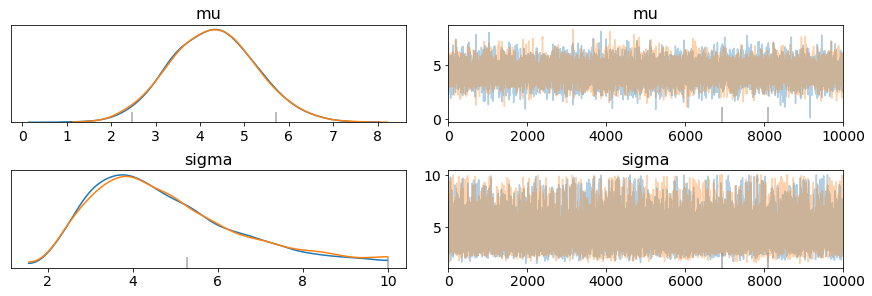

In [10]:
print(pm.summary(trace_mv))
pm.traceplot(trace_mv)

The summary output gives us a lot of useful information, including the mean and some intervals. Rhat gives an indication of how similar the chains are and whether or not there may be issues with convergence. The plots give us a nice visual description of the chains as well. Here we can see that they are both very similar (as also indicated by the Rhat values). We can see the distribution of the standard deviation does indeed follow a gamma pattern. Although we have a better idea of our parameters (especially for standard deviation), those warnings we got earlier are still worrisome. Let's address those by using the results to make new priors for the mean and standard deviation and "gather" new data to update them. That is the beauty of Bayesian inference after all!

Note: Look how easy pymc3 makes it to specify the gamma distribution!

In [11]:
from scipy.stats import gamma

# New Data
np.random.seed(42)
new_N = 10
new_data = np.random.normal(data_m,
                        data_sd,
                        N)
new_prior_m = pm.summary(trace_mv)['mean'][0]
new_prior_sd = pm.summary(trace_mv)['sd'][0]

# Specify new model
with pm.Model() as new_model:
    
    # Prior
    mu = pm.Normal('mu', mu=prior_m, sigma=prior_sd)
    sigma = pm.Gamma('sigma',
                     mu=pm.summary(trace_mv)['mean'][1], 
                     sigma=pm.summary(trace_mv)['sd'][1])
    
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=new_data)
    
    trace_new_model = pm.sample(10000,random_seed=42, target_accept=.9)

trace_new_model_df = pm.trace_to_dataframe(trace_new_model)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:10<00:00, 1920.09draws/s]


No warnings! Looks like our adjustments improved the model.

In [12]:
pm.summary(trace_new_model)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.455307,0.854497,0.007748,2.699346,6.062183,12500.041477,0.999966
sigma,3.467728,1.124261,0.011926,1.606722,5.694858,10890.242920,1.000084


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c29f0c518>,
      dtype=object)

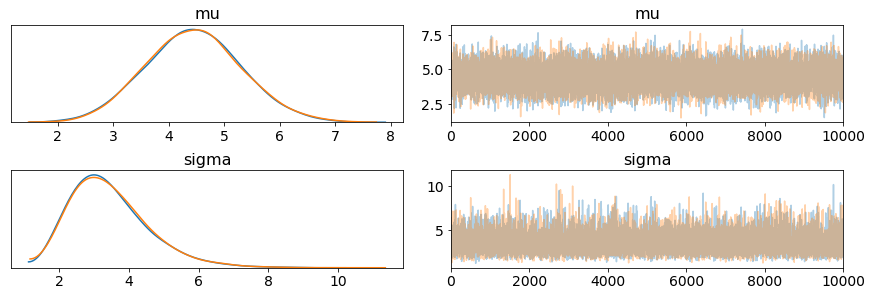

In [13]:
pm.traceplot(trace_new_model)

That was pretty easy! Now I'll plot how these parameters have changed as they've been updated with more data.

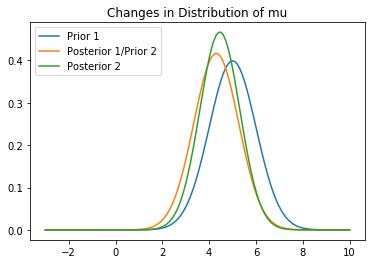

Prior mean = 5 
 Sample 1 mean = 1.807955484797241 N = 5 
 Sample 2 mean = 3.377008922975258 N = 10


In [14]:
plt.plot(x,
        norm.pdf(x,
                prior_m,
                prior_sd))
plt.plot(x,
        norm.pdf(x,
                new_prior_m,
                new_prior_sd))
plt.plot(x,
        norm.pdf(x,
                pm.summary(trace_new_model)['mean'][0],
                pm.summary(trace_new_model)['sd'][0]))
plt.legend(['Prior 1', 'Posterior 1/Prior 2', 'Posterior 2'])
plt.title('Changes in Distribution of mu')
plt.show()
print(f'Prior mean = {prior_m}','\n',
     f'Sample 1 mean = {data.mean()} N = {N}', '\n',
     f'Sample 2 mean = {new_data.mean()} N = {new_N}')

We can see here how the posterior changes based on new data (new samples were drawn from a normal distribution with mean = 2 and standard deviation of 3). Now let's take a look at how the standard deviation distribution changes with new data.

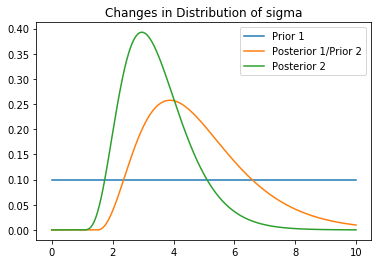

In [15]:
from scipy.stats import uniform
sd_x = np.arange(0,10,.01)
prior_2a, prior_2l, prior_2b = gamma.fit(trace_mv_df['sigma'])
post_a, post_l, post_b = gamma.fit(trace_new_model_df['sigma'])

plt.plot(sd_x,
        uniform.pdf(sd_x,0,10))
plt.plot(sd_x,
        gamma.pdf(sd_x,prior_2a, prior_2l,prior_2b))
plt.plot(sd_x,
        gamma.pdf(sd_x, post_a, post_l, post_b))
plt.legend(['Prior 1', 'Posterior 1/Prior 2', 'Posterior 2'])
plt.title('Changes in Distribution of sigma')
plt.show()

This was just a very simple demonstration of some very simple models, but these types of exercises are a great way of getting/reinforcing some intuition of how Bayesian inference and MCMC methods work and can be executed. In practice, MCMC methods via pymc3 can handle a ton of different types of simple and extremely complex models. I haven't had a lot of reason to use Bayesian methods in my day-to-day work, but the more I learn about them the more interesting I find the possibilities. One final obvious note is that although these models are powerful, they are also computationally expensive. It seems like algorithms have come a long way in terms of efficiency, but complex models will still require more resources and time that non-Bayesian approaches. I don't think I'll ever use either frequentist or Bayesian approaches exclusively, but it's really helpful to have both options available.